# Semi Regular Polygon (3.3.3.3.6)

We define some scripts to create the cutting patterns for one of the 8 semi-regular tesselations.<br>
In particular for the triangle + hexagon tesselation defined by vertex `(3.3.3.3.6)`.

### Strategy

- We define a basic shape made of 1 hexagon and 8 triangles using python library [Shapely](https://shapely.readthedocs.io/en/stable/manual.html).<br>
- We fill a portion of the plane with copies of this shape.
- We remove the polygons outside the frame which defines the shape of the riser
- We use the **Shapely** set operation "difference" to trip shapes too close to the edge (leaving some margin for welding the risers)


### Process Overview

<img src="./img/process_overview.png" width="80%">

In [523]:
# Imports
import math

from shapely.geometry import Polygon
from shapely import affinity, polygons

import matplotlib.pyplot as plt

In [524]:
import sys
sys.path.append('../..')  # Add the parent directory to Python path
from polygon_utils import (
    create_regular_polygon,
    plot_polygon_dict,
    plot_polygon_list,
    blue_plot,
    center_rectangle_on_polygons,
    is_polygon_inside_frame,
    save_polygon_list_to_svg,
    crop_and_save_tile,
)

### Canvas and Polygon sizes

In [525]:
# DRAWING PARAMS:
drawing_height = 300
drawing_width = 1200
tabica_height = 170
tabica_width = 908

hexagon_radius = 25 # 26
triangle_radius = hexagon_radius * math.sin(math.pi/6)/math.sin(math.pi/3)

frame_shift = -1  # move box that selects region of interest down by Xmm
INSET_DISTANCE = 3   # X ratio gives gaps of about 2Xmm solid channels

bottom_margin = 26 # solid margin, at bottom of step
top_margin = tabica_height - 120 - bottom_margin # solid margin, at top of step

side_margin = 16 # solid margin left and right

### Polygon creation

In [526]:
def create_regular_polygon(center_x, center_y, radius, nr_points):
    angle = 2 * math.pi / nr_points
    polygon_points = []

    for i in range(nr_points):
        x = center_x + radius * math.cos(i * angle)
        y = center_y + radius * math.sin(i * angle)
        polygon_points.append((x, y))

    return Polygon(polygon_points)

# Create a triangle (3 sides)
triangle = create_regular_polygon(0,0,triangle_radius, 3)

# Create a hexagon (6 sides)
hexagon = create_regular_polygon(0,0,hexagon_radius, 6)

### Dictionary of Polygons

Here we save a dictionary of polygons.

The reason for using a dictionary is to be able to plot polygon with its key representing its label.
This allows us to easily visualize the transforms that define the position of the polygon.

In [527]:
# translate_x = 0   # Translate 50mm on the X axis
# translate_y = triangle_radius/2 + hexagon_radius*math.cos(math.pi/6)   # Translate 50mm on the Y axis

triangle_up = affinity.rotate(triangle, 90, origin="centroid")
triangle_down = affinity.rotate(triangle, -90, origin="centroid")

polygon_dict = {}
polygon_dict['H0'] = hexagon
# polygon_dict['T0'] = triangle
polygon_dict['T1'] = affinity.translate(triangle_up, 
                                 -2*triangle_radius*math.sin(math.pi/3),
                                 -triangle_radius)
 
polygon_dict['T2'] = affinity.translate(triangle_down, 
                                 -2*triangle_radius*math.sin(math.pi/3),
                                 -2*triangle_radius)

polygon_dict['T3'] = affinity.translate(triangle_up, 
                                 -triangle_radius*math.sin(math.pi/3),
                                 -triangle_radius - hexagon_radius*math.cos(math.pi/6))

polygon_dict['T4'] = affinity.translate(triangle_down, 
                                 0,
                               -triangle_radius/2 - hexagon_radius*math.cos(math.pi/6))
                                 
polygon_dict['T5'] = affinity.translate(triangle_up,
                                +triangle_radius*math.sin(math.pi/3),
                                -triangle_radius - hexagon_radius*math.cos(math.pi/6))                                 

polygon_dict['T6'] = affinity.translate(triangle_down,
                                +2*triangle_radius*math.sin(math.pi/3),
                                -2*triangle_radius)

polygon_dict['T7'] = affinity.translate(triangle_up,
                                +2*triangle_radius*math.sin(math.pi/3),
                                -triangle_radius)

polygon_dict['T8'] = affinity.translate(triangle_down,
                                +3*triangle_radius*math.sin(math.pi/3),
                                -triangle_radius/2)
        

### Plotting Dictionaries of Shapes

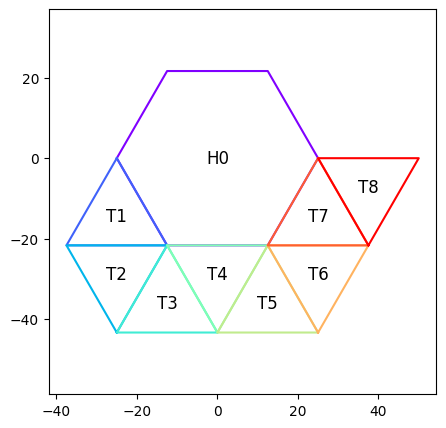

In [528]:
plot_polygon_dict(polygon_dict)

### Translations
The collection of polygons above can be translated to fill the plane as shown below:

In [529]:
# Define the translation
x_offset = 4*triangle_radius*math.sin(math.pi/3)
y_offset = 2*hexagon_radius*math.sin(4*math.pi/6)

# Translate all polygons
translated_polygons = {
    f"{key}-t": affinity.translate(poly, x_offset, y_offset) for key, poly in polygon_dict.items()
}

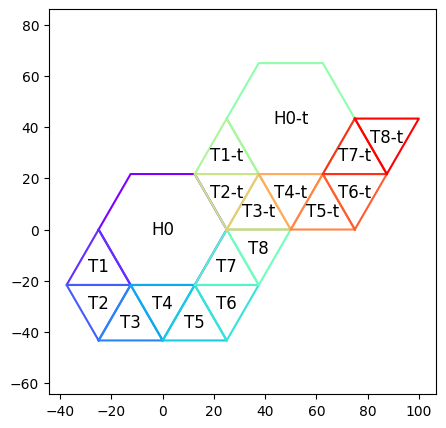

In [530]:
super_polys = {**polygon_dict, **translated_polygons}
plot_polygon_dict(super_polys)

## List of Polygons

In order to generate the full list of polygons that fill the plane, we will store them in a list
instead of a dictionary.  <br>The basic idea is to use the basic initial shape
and apply a series of translations to generate the full list of polygons.

In [531]:
initial_polygon_list = list(polygon_dict.values())

### Plane Translations

We define two translations
- Up and to the right (as shown in plot above)
- Down and to the right 

In [532]:
# Translate all polygons
def translate_polygon_up(polygon_list): 
    """
    takes a list of polygons and applies the up and to the right
    unit translation.  It returns a new list of polygons 
    with the translation applied
    """
    
    # Define the basic UP + RIGHT translation
    x_up = 4*triangle_radius*math.sin(math.pi/3)
    y_up = 2*hexagon_radius*math.sin(4*math.pi/6)
    
    up_polygons = [
    affinity.translate(poly, x_up, y_up) for poly in polygon_list
    ]
    return up_polygons

def translate_polygon_down(polygon_list, nr_translations):
    """
    takes a list of polygons and applies the down and to the right
    unit translation.  It returns a new list of polygons 
    with the translation applied
    """
    # Define the basic DOWN + RIGHT translation
    x_down = 5*triangle_radius*math.sin(math.pi/3) * nr_translations
    y_down = -hexagon_radius*math.sin(4*math.pi/6) * nr_translations

    down_polygons = [
    affinity.translate(poly, x_down, y_down) for poly in polygon_list
    ]
    return down_polygons


### Plotting Lists of Polygons

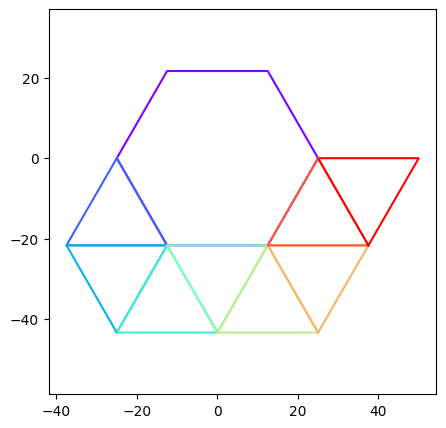

In [533]:
initial_polygon_list = list(polygon_dict.values())
plot_polygon_list(initial_polygon_list)

### Translation Strategy

1. We create a tilted column made of copies of the "basic polygon group"
   * This column is created by translating the last copied group to the right and up
   * We repeat this process until we have a big enough column (about 8 or 9 copies)

 2. We return to the base of the column, and translate one "basic polygon group" down to the right
and start growing back up the column.  We repeat this process until we have a big enough surface.

Note that to avoid the column spreading too far, we reduce the number of copies of the "basic polygon group" as we move to the right.

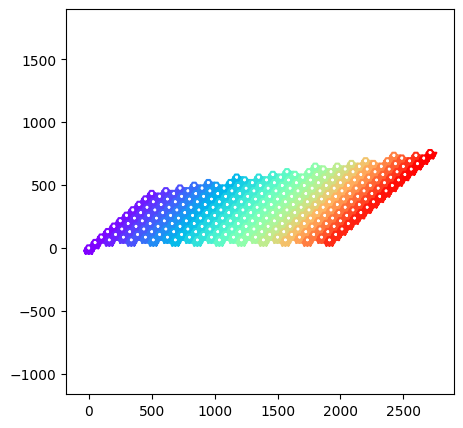

In [534]:
initial_polygon_list = list(polygon_dict.values())

temp_poly_group = initial_polygon_list
full_polygon_list = []
full_polygon_list = full_polygon_list + initial_polygon_list

index_to_the_right = 22
index_up = 10

for k in range(index_to_the_right): # index to the right
    if k > 0:
        tmp_poly_group = translate_polygon_up(initial_polygon_list)
        for _ in range(math.floor(k/2)):
            tmp_poly_group = translate_polygon_up(tmp_poly_group)
    else:
        tmp_poly_group = initial_polygon_list
    tmp_poly_group = translate_polygon_down(tmp_poly_group, k)
    # tmp_poly_group = translate_polygon_up(tmp_poly_group)
    for _ in range(index_up + math.floor(k/3)): # index up
        temp_poly_group = translate_polygon_up(tmp_poly_group)
        full_polygon_list += temp_poly_group
        tmp_poly_group = temp_poly_group
    

plot_polygon_list(full_polygon_list)


# FRAME

The frame defines the rectangle that will become the cut sheet metal.
We want to delete polygons outside of this frame, and potentially "trim" some of the polygons at the edges,
to ensure the sheet metal can we welded robustly to the next piece.

In [535]:
frame = polygons([[0,0],
                  [0 + tabica_width, 0],
                  [0 + tabica_width, 0 + tabica_height],
                  [0, 0 + tabica_height]])

In [536]:
# Center the rectangle
centered_frame = center_rectangle_on_polygons(full_polygon_list, frame)

In [537]:
centered_frame = affinity.translate(centered_frame, 0, frame_shift)

### Function to center frame around the polygons

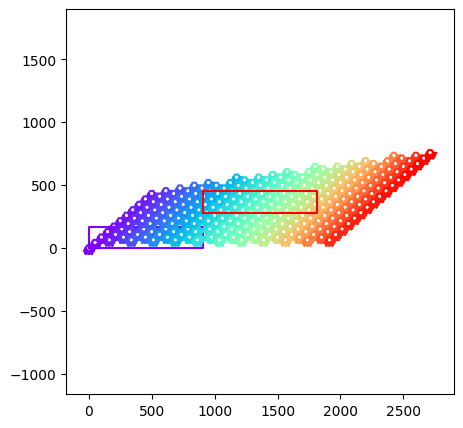

In [538]:
plot_polygon_list([frame] + full_polygon_list + [centered_frame])

### Delete polygons *mostly* outside of frame

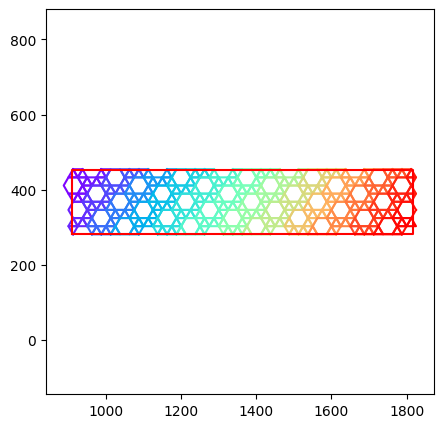

In [539]:
# Filter the full_polygon_list to keep only polygons "mostly" inside the rectangle
# by "mostly" we mean that the centroid of the polygon lies outside the frame.
filtered_polygon_list = [polygon for polygon in full_polygon_list if is_polygon_inside_frame(polygon, centered_frame)]

# Update the full_polygon_list
full_polygon_list = filtered_polygon_list

# Plot the polygons
plot_polygon_list(full_polygon_list + [centered_frame])

## Perform Inset Operation on polygons
This shrinks each polygon to leave some material between them by a specified amount

In [540]:
inset_polygon_list = []
for poly in full_polygon_list:
    inset_polygon_list.append(poly.buffer(-INSET_DISTANCE))  

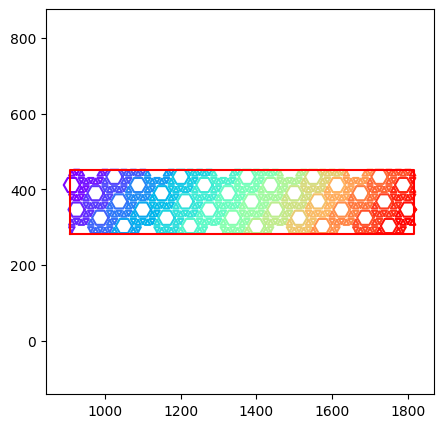

In [541]:
plot_polygon_list(inset_polygon_list + [centered_frame])

## Create Inner Tile to cut polygons
Inner tile is:

- 22 cm inside the frame (left and right)
- 26 cm higher than the bottom border of the frame
- centered horizontally
- 120 cm tall

In [542]:
# Get frame bounds for calculations
xmin, ymin, xmax, ymax = centered_frame.bounds

# Inner tile margins (in centimeters)
left_inset = 16
right_inset = 16
bottom_inset = 26

# Calculate new xmin and xmax (sides inset by 22 cm)
inner_xmin = xmin + left_inset
inner_xmax = xmax - right_inset

# Calculate new ymin (bottom inset by 26 cm)
inner_ymin = ymin + bottom_inset

# The top of the inner tile is flush with the top of the frame
inner_ymax = inner_ymin + 120

# Create the inner tile polygon
from shapely.geometry import Polygon

inner_tile = Polygon([
    (inner_xmin, inner_ymin),
    (inner_xmin, inner_ymax),
    (inner_xmax, inner_ymax),
    (inner_xmax, inner_ymin)
])

### Use inner tile to crop polygons

369


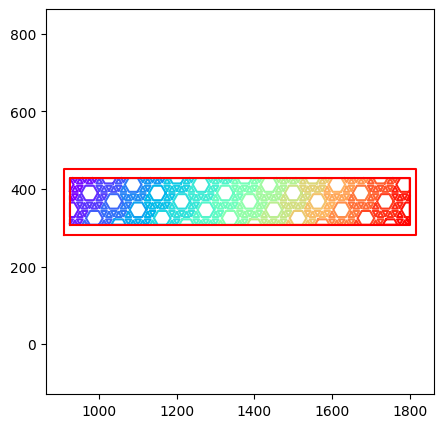

In [543]:
poly_crop = crop_and_save_tile(inset_polygon_list, inner_tile, save_holes=False)
plot_polygon_list(poly_crop + [centered_frame, inner_tile])

In [544]:
final_polygons =  poly_crop + [centered_frame]


# SANITY CHECKS

- delete any polygon with an area less than a threshold

In [545]:
len(final_polygons)

280

In [546]:
# remove holes that are too small
final_export_list = [
    p for p in poly_crop 
    if hasattr(p, 'area') and p.area >= 21
]

In [547]:
final_polygons = final_export_list + [centered_frame]
len(final_polygons)

280

### Save POLYGONS to SVG

In [548]:
save_polygon_list_to_svg(final_polygons, filename='tabica_2.4.svg')

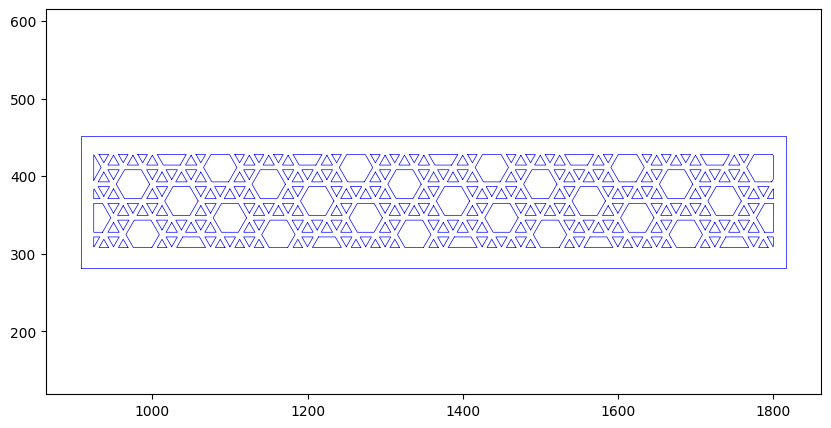

In [549]:
blue_plot(final_polygons)

In [550]:
# Save as PNG
plt.figure(figsize=(12, 8))
for polygon in (final_polygons):
    x, y = polygon.exterior.xy
    plt.plot(x, y, color='blue', linewidth=0.5)
plt.axis('equal')
plt.savefig('tabica_2.4.png', dpi=300, bbox_inches='tight')
plt.close()